## **Data Collection and Exploration**

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import nltk
import re
import seaborn as sns
import sqlite3
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

### About the Data


Information from the Flipkart India webpage is retrieved, comprising a total of 83 tables. Among them, one table provides details about the remaining 82 tables, which, in turn, house reviews for 82 different mobile phones.

A table detailing information about mobile phones possesses the following attributes.

- product_id    
- product_name  
- price         
- category      
- sub_category  
- specifications
- ratings       
- discount      
- moreinfo      

Tables that encompass reviews for 82 mobile phones possess the following attributes.

- product_id  
- review_id   
- title       
- review      
- likes       
- dislikes    
- ratings     
- reviewer    



In [64]:
# sqlite query results into a pandas DF
data_path = "/content/drive/My Drive/flipkart_products.db"
conn = sqlite3.connect(data_path)
ecomm_items = pd.read_sql_query("SELECT * from items", conn)
conn.close()

In [65]:
ecomm_items.head(2)

,product_id,product_name,price,category,sub_category,specifications,ratings,discount,moreinfo
0,ECMB000001,"Redmi 9A (SeaBlue, 32 GB)","₹7,413",Electronics,Mobile,2 GB RAM | 32 GB ROM16.59 cm (6.53 inch) Full ...,4.3,3.0,/redmi-9a-seablue-32-gb/p/itmeabd39a0cd669?pid...
1,ECMB000002,"Redmi 9A (Midnight Black, 32 GB)","₹7,421",Electronics,Mobile,2 GB RAM | 32 GB ROM16.59 cm (6.53 inch) Full ...,4.3,3.0,/redmi-9a-midnight-black-32-gb/p/itmeabd39a0cd...


In [66]:
ecomm_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   product_id      82 non-null     object
 1   product_name    82 non-null     object
 2   price           82 non-null     object
 3   category        82 non-null     object
 4   sub_category    82 non-null     object
 5   specifications  82 non-null     object
 6   ratings         82 non-null     object
 7   discount        34 non-null     object
 8   moreinfo        82 non-null     object
dtypes: object(9)
memory usage: 5.9+ KB


**Inights:**

- The dataset comprises 82 entries and 9 columns, stored as a pandas DataFrame.

- All columns have 82 non-null entries, indicating a complete dataset with no missing values.

- The 'discount' column is incomplete, with only 34 entries containing discount information.

- The dataset's memory usage is relatively low, approximately 5.9 KB.

In [67]:
conn = sqlite3.connect(data_path)
products_data = pd.read_sql_query("SELECT * from ECMB000001", conn)

for i in range(2, len(ecomm_items) + 1):

    products_df_temp = pd.read_sql_query("SELECT * from ECMB{:06d}".format(i), conn)
    products_data = pd.concat([products_data, products_df_temp])
conn.close()

In [68]:
products_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53493 entries, 0 to 289
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  53493 non-null  object
 1   review_id   53493 non-null  object
 2   title       53493 non-null  object
 3   review      53493 non-null  object
 4   likes       53493 non-null  object
 5   dislikes    53493 non-null  object
 6   ratings     48488 non-null  object
 7   reviewer    53493 non-null  object
dtypes: object(8)
memory usage: 3.7+ MB


**Insights:**

- The dataset is a pandas DataFrame with 53,493 entries and 8 columns.

- All columns, including 'ratings,' have 53,493 non-null entries, indicating a complete dataset.

- The 'ratings' column has 4,488 missing values, suggesting potential gaps in the rating information.

- The dataset's memory usage is relatively high, approximately 3.7 MB.

In [69]:
products_data.head()

,product_id,review_id,title,review,likes,dislikes,ratings,reviewer
0,ECMB000001,ECMB0000010000001,Excellent,Wow superb I love it❤️👍 battery backup so nice 👍👍,740,160,5,Abhishek Saini
1,ECMB000001,ECMB0000010000002,Worth the money,Mobile So Good In Range Redmi 9a Has Miui 12 L...,355,104,4,Dinesh Kumar Sahni
2,ECMB000001,ECMB0000010000003,Just wow!,Wonderful device and smart phone best camera b...,125,47,5,Flipkart Customer
3,ECMB000001,ECMB0000010000004,Simply awesome,Very good mobile. Value for money. Battery bac...,0,0,5,Amit Sen
4,ECMB000001,ECMB0000010000005,Highly recommended,Really great.... value for money...,90,15,5,Sudeshna pakira


### Handling Missing Values

Incomplete data is a common occurrence in real-world datasets, and as the dataset size grows, the likelihood of encountering missing values also increases. Various factors can contribute to missing data, including:

- Merging of source datasets
- Random events
- Failures in measurement

<Figure size 100x200 with 0 Axes>

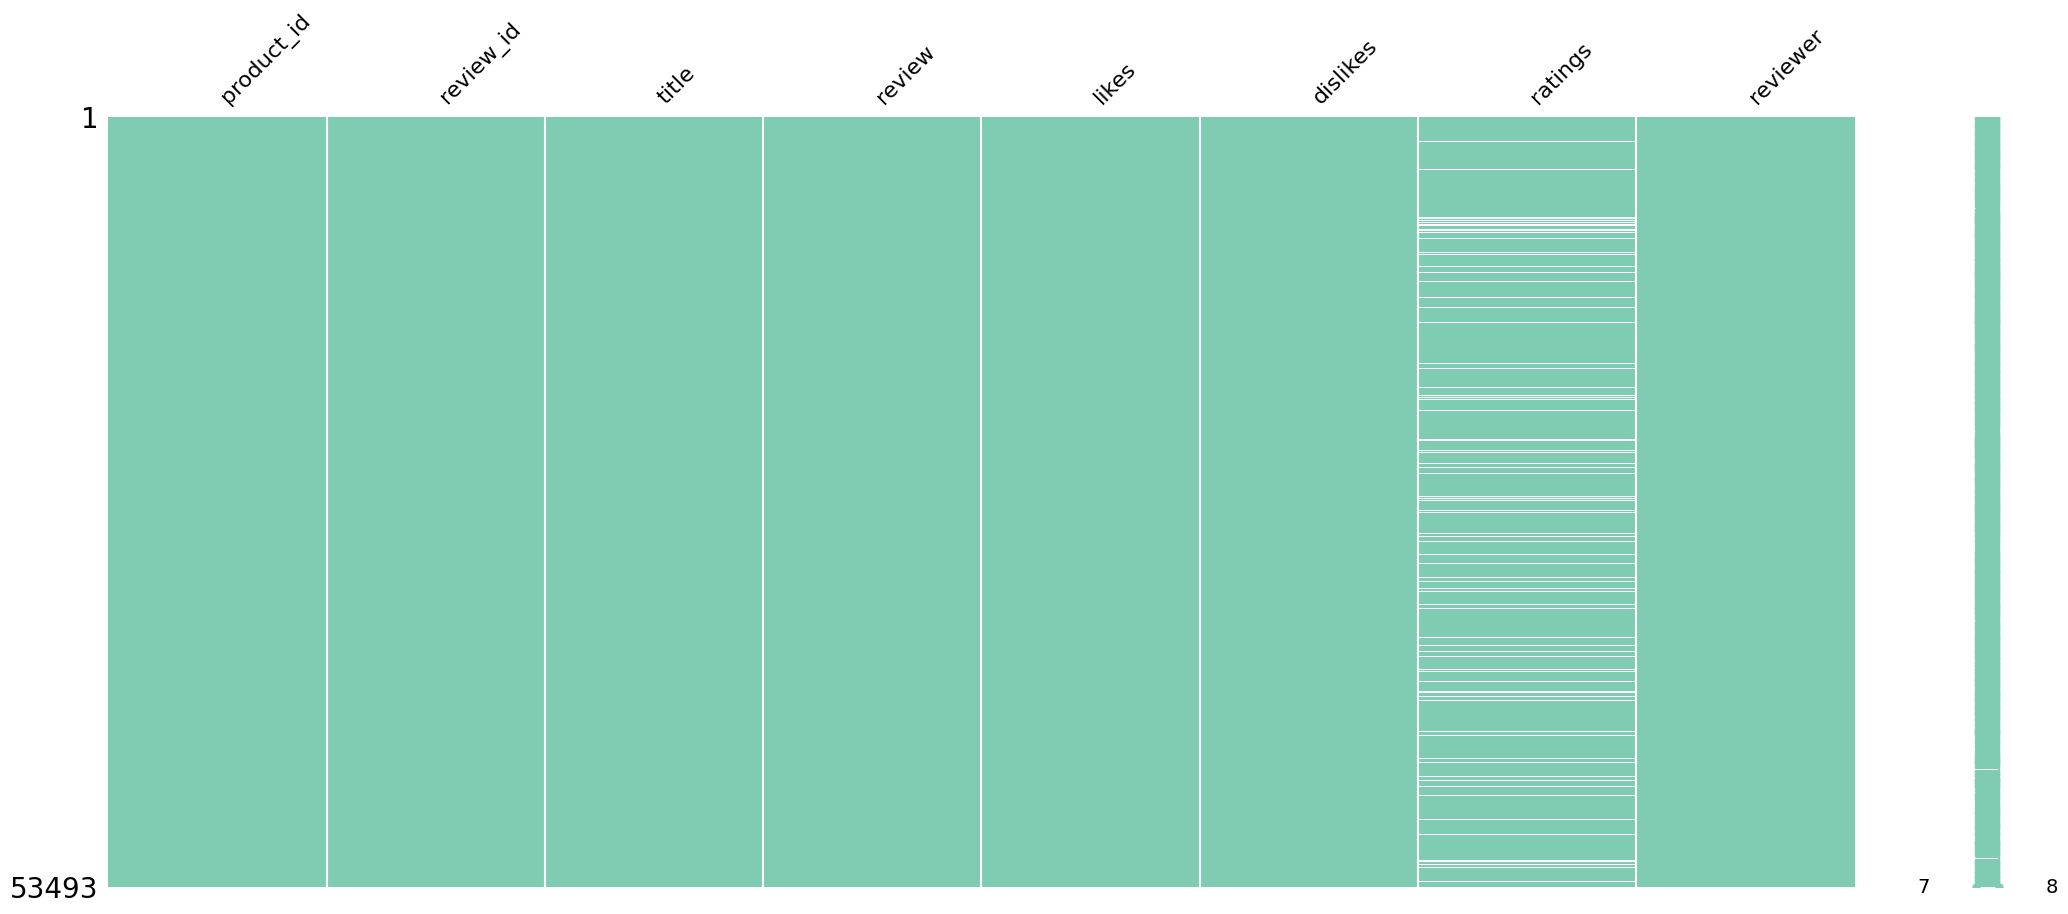

In [70]:
plt.figure(figsize=(1, 2))
msno.matrix(products_data, color=[0.5,0.8,0.7])
plt.show()


We can handle missing values using lots of techniques like simple statistical methods, using machine learning models and many more but in this case majority of missing values are from ratings column and we will use that column as label column later so I don't want to fake out or ruin the original distribution of the label data specially so thats why I will be dropping the rows having missing values in column ratings. Dropping technique in never recommended but in this senario I am using it.  

In [71]:
# Dropping the rows with missing values
products_data.dropna(inplace=True, axis=0)
products_data.isna().sum()

,0
product_id,0
review_id,0
title,0
review,0
likes,0
dislikes,0
ratings,0
reviewer,0


Now, after dealing with null occurences, the data is completely free from null noise.

<Figure size 1500x800 with 0 Axes>

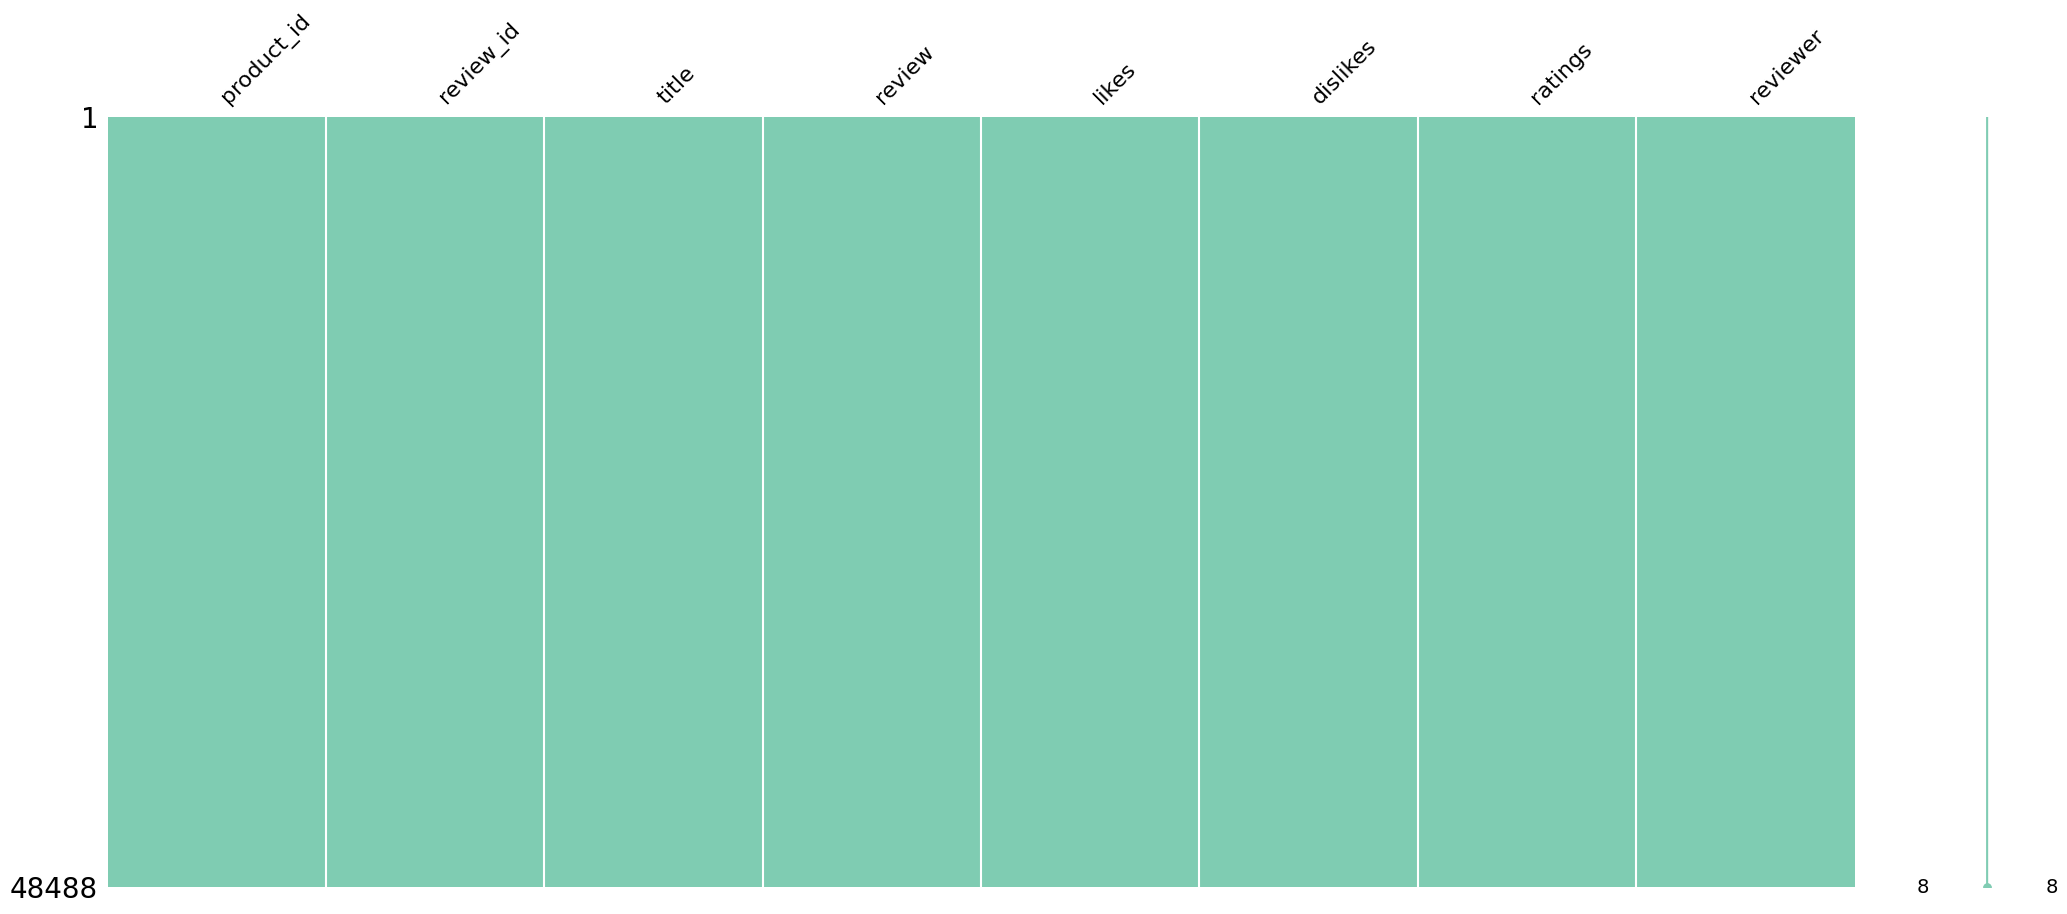

In [72]:
plt.figure(figsize=(15, 8))
msno.matrix(products_data, color=[0.5,0.8,0.7])
plt.show()

### Exploratory Data Analysis

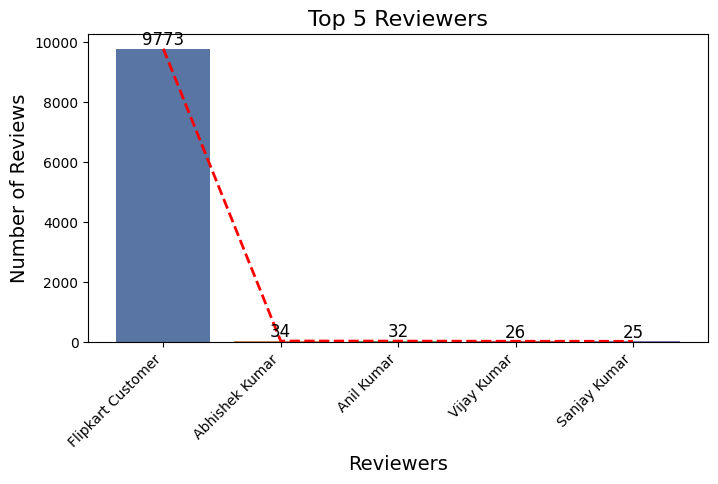

In [73]:
# Visualization 2: Barplot of Top Reviewers
top_reviewers = products_data['reviewer'].value_counts().nlargest(5)
plt.figure(figsize=(8, 4))

# Create a barplot
barplot = sns.barplot(x=top_reviewers.index, y=top_reviewers.values, palette='deep')  # Correct the palette name
plt.title('Top 5 Reviewers', fontsize=16)
plt.xlabel('Reviewers', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Annotate each bar with its value
for i, value in enumerate(top_reviewers.values):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom', fontsize=12)

# Create a red line plot connecting the tops of all bars
x_coords = range(len(top_reviewers))
y_coords = top_reviewers.values
plt.plot(x_coords, y_coords, color='red', linestyle='--', linewidth=2)

plt.show()


**Insights:**

- "Flipkart Customer" is the leading reviewer with a substantial count of 9,773 reviews.

- Following the top reviewer, the next four contributors are individuals named "Abhishek Kumar," "Anil Kumar," "Vijay Kumar," and "Sanjay Kumar."

- "Abhishek Kumar" has 34 reviews, "Anil Kumar" has 32, "Vijay Kumar" has 26, and "Sanjay Kumar" has 25.

- The distribution of review counts suggests a mix of both prolific and moderately active reviewers.


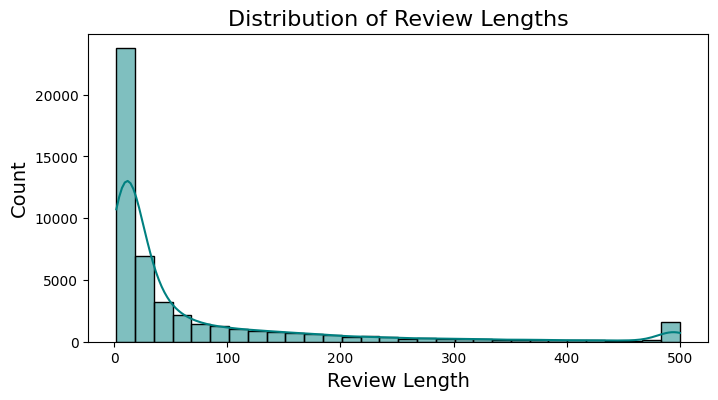

In [74]:
# Visualization 3: Distribution of Review Lengths
products_data['review_length'] = products_data['review'].apply(len)
plt.figure(figsize=(8,4))
sns.histplot(products_data['review_length'], bins=30, color='teal', kde=True)
plt.title('Distribution of Review Lengths', fontsize=16)
plt.xlabel('Review Length', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

**Insights:**

- The peak in the KDE plot indicates the central tendency of review lengths, and in this case, it suggests a concentration around 70 characters.

- The width of the KDE plot provides insights into the variability of review lengths. A wider plot signifies higher variability, supported by the standard deviation of 114.8.

- The KDE plot asymmetry, if present, could indicate skewness in the distribution, influencing the mean and median values.

- Multiple peaks in the KDE plot might suggest the presence of distinct subgroups or patterns within the review lengths.

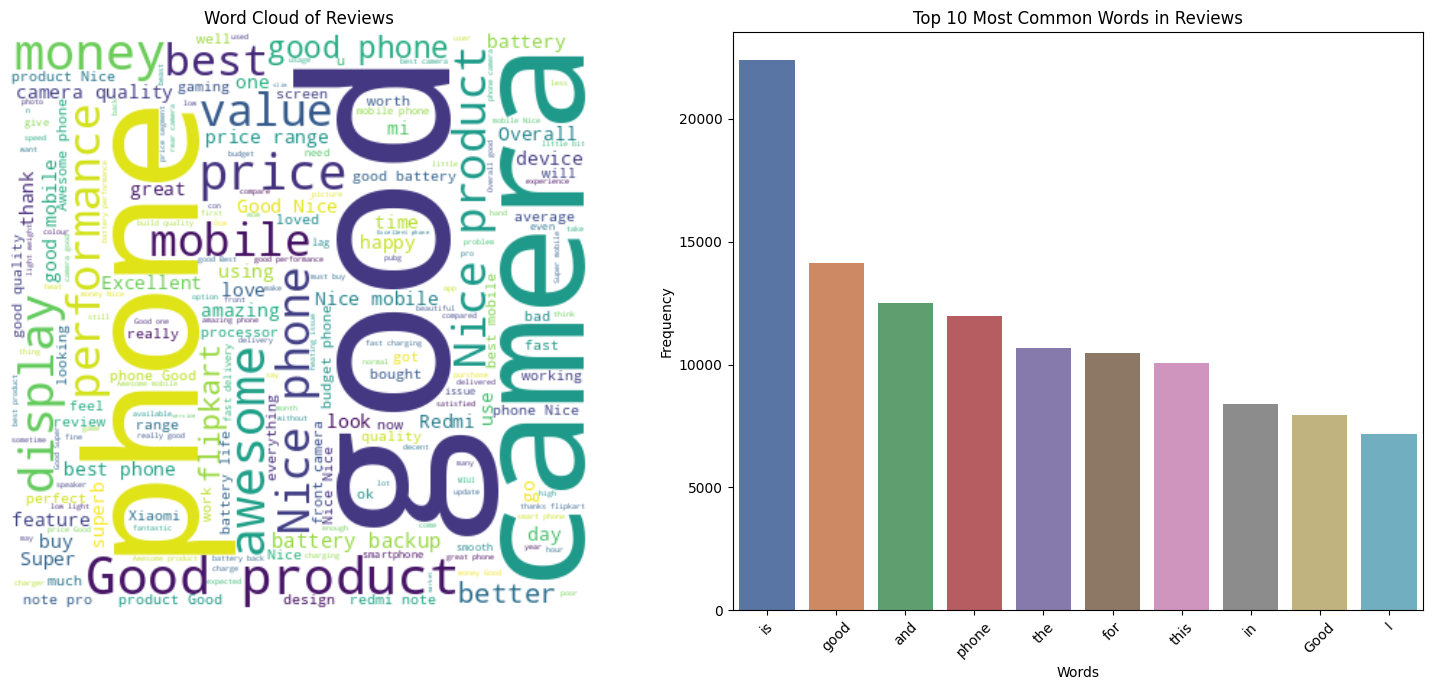

In [75]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Tokenize words from reviews
words = ' '.join(products_data['review']).split()

# Create a word cloud
wordcloud = WordCloud(width=400, height=400, background_color='white').generate(' '.join(words))

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Plot the word cloud
axes[0].imshow(wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud of Reviews')

# Create a bar plot of the most common words
word_counts = Counter(words)
common_words = word_counts.most_common(10)

sns.barplot(x=[word[0] for word in common_words], y=[word[1] for word in common_words], palette='deep', ax=axes[1])
axes[1].set_title('Top 10 Most Common Words in Reviews')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


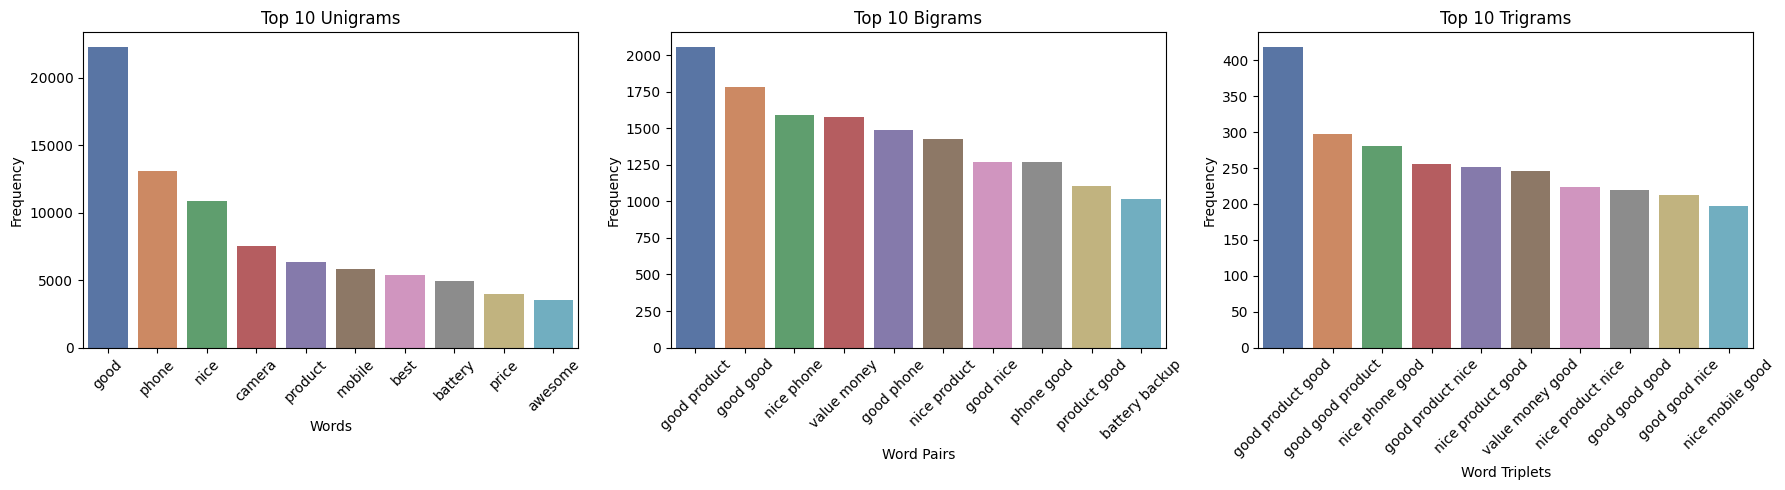

In [76]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import ngrams

# Download NLTK stopwords
import nltk
nltk.download('stopwords')

# Tokenize words from reviews and remove stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word.lower() for word in ' '.join(products_data['review']).split() if word.lower() not in stop_words]

# Create unigrams
unigrams = Counter(filtered_words)
top_unigrams = unigrams.most_common(10)

# Create bigrams
bigrams = Counter(ngrams(filtered_words, 2))
top_bigrams = bigrams.most_common(10)

# Create trigrams
trigrams = Counter(ngrams(filtered_words, 3))
top_trigrams = trigrams.most_common(10)

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot unigrams
sns.barplot(x=[word[0] for word in top_unigrams], y=[word[1] for word in top_unigrams], palette='deep', ax=axes[0])
axes[0].set_title('Top 10 Unigrams')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

# Plot bigrams
sns.barplot(x=[' '.join(word[0]) for word in top_bigrams], y=[word[1] for word in top_bigrams], palette='deep', ax=axes[1])
axes[1].set_title('Top 10 Bigrams')
axes[1].set_xlabel('Word Pairs')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)

# Plot trigrams
sns.barplot(x=[' '.join(word[0]) for word in top_trigrams], y=[word[1] for word in top_trigrams], palette='deep', ax=axes[2])
axes[2].set_title('Top 10 Trigrams')
axes[2].set_xlabel('Word Triplets')
axes[2].set_ylabel('Frequency')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


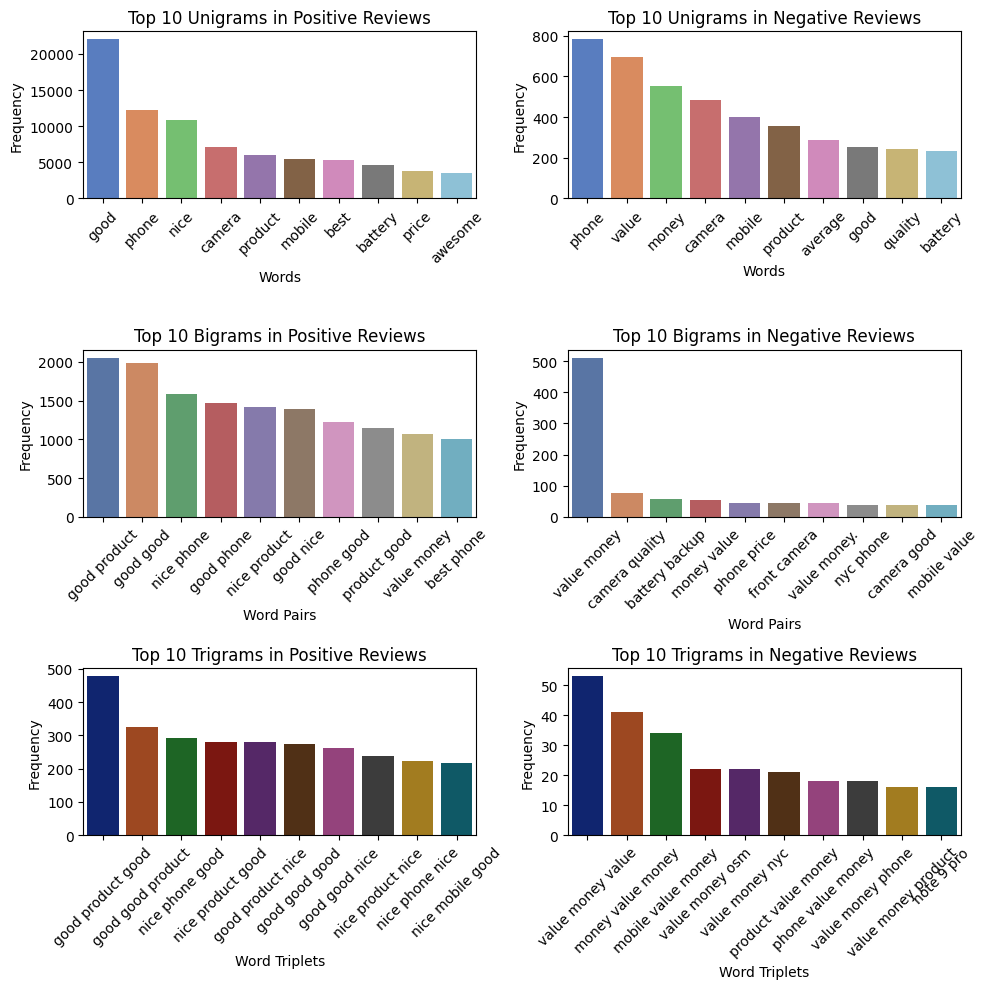

In [77]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import ngrams
from textblob import TextBlob

# Download NLTK stopwords
import nltk
nltk.download('stopwords')

# Function to get polarity of a review
def get_review_polarity(review):
    analysis = TextBlob(review)
    return 'positive' if analysis.sentiment.polarity > 0 else 'negative'

# Apply polarity to each review
products_data['polarity'] = products_data['review'].apply(get_review_polarity)

# Tokenize words from reviews and remove stopwords
stop_words = set(stopwords.words('english'))
filtered_words_positive = [word.lower() for word in ' '.join(products_data[products_data['polarity'] == 'positive']['review']).split() if word.lower() not in stop_words]
filtered_words_negative = [word.lower() for word in ' '.join(products_data[products_data['polarity'] == 'negative']['review']).split() if word.lower() not in stop_words]

# Create unigrams
unigrams_positive = Counter(filtered_words_positive)
unigrams_negative = Counter(filtered_words_negative)
top_unigrams_positive = unigrams_positive.most_common(10)
top_unigrams_negative = unigrams_negative.most_common(10)

# Create bigrams
bigrams_positive = Counter(ngrams(filtered_words_positive, 2))
bigrams_negative = Counter(ngrams(filtered_words_negative, 2))
top_bigrams_positive = bigrams_positive.most_common(10)
top_bigrams_negative = bigrams_negative.most_common(10)

# Create trigrams
trigrams_positive = Counter(ngrams(filtered_words_positive, 3))
trigrams_negative = Counter(ngrams(filtered_words_negative, 3))
top_trigrams_positive = trigrams_positive.most_common(10)
top_trigrams_negative = trigrams_negative.most_common(10)

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

# Plot unigrams
sns.barplot(x=[word[0] for word in top_unigrams_positive], y=[word[1] for word in top_unigrams_positive], palette='muted', ax=axes[0, 0])
axes[0, 0].set_title('Top 10 Unigrams in Positive Reviews')
axes[0, 0].set_xlabel('Words')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.barplot(x=[word[0] for word in top_unigrams_negative], y=[word[1] for word in top_unigrams_negative], palette='muted', ax=axes[0, 1])
axes[0, 1].set_title('Top 10 Unigrams in Negative Reviews')
axes[0, 1].set_xlabel('Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot bigrams
sns.barplot(x=[' '.join(word[0]) for word in top_bigrams_positive], y=[word[1] for word in top_bigrams_positive], palette='deep', ax=axes[1, 0])
axes[1, 0].set_title('Top 10 Bigrams in Positive Reviews')
axes[1, 0].set_xlabel('Word Pairs')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].tick_params(axis='x', rotation=45)

sns.barplot(x=[' '.join(word[0]) for word in top_bigrams_negative], y=[word[1] for word in top_bigrams_negative], palette='deep', ax=axes[1, 1])
axes[1, 1].set_title('Top 10 Bigrams in Negative Reviews')
axes[1, 1].set_xlabel('Word Pairs')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].tick_params(axis='x', rotation=45)

# Plot trigrams
sns.barplot(x=[' '.join(word[0]) for word in top_trigrams_positive], y=[word[1] for word in top_trigrams_positive], palette='dark', ax=axes[2, 0])
axes[2, 0].set_title('Top 10 Trigrams in Positive Reviews')
axes[2, 0].set_xlabel('Word Triplets')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].tick_params(axis='x', rotation=45)

sns.barplot(x=[' '.join(word[0]) for word in top_trigrams_negative], y=[word[1] for word in top_trigrams_negative], palette='dark', ax=axes[2, 1])
axes[2, 1].set_title('Top 10 Trigrams in Negative Reviews')
axes[2, 1].set_xlabel('Word Triplets')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


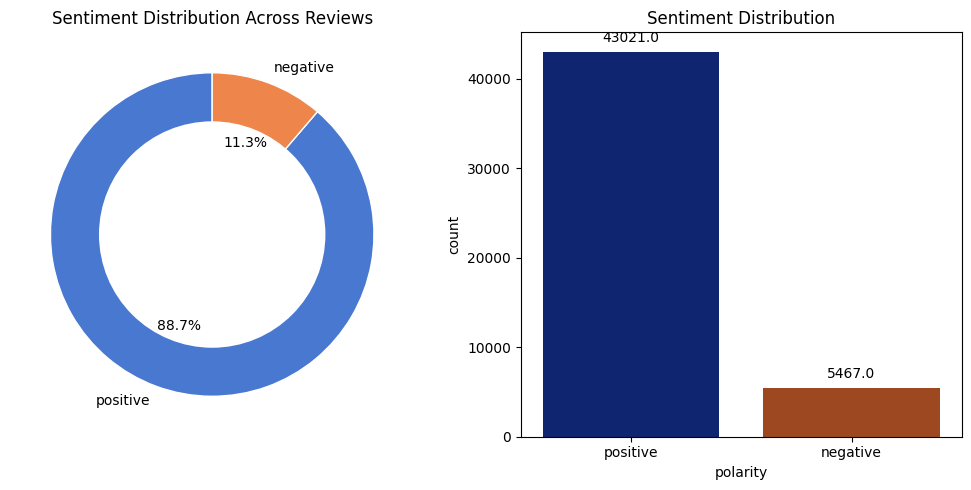

In [78]:
# Apply polarity to each review
products_data['polarity'] = products_data['review'].apply(get_review_polarity)

# Count the number of positive and negative reviews
sentiment_counts = products_data['polarity'].value_counts()

# Set up figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Donut plot for sentiment distribution
ax1.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4, edgecolor='w'), colors=sns.color_palette("muted"))

# Draw circle in the center for the donut plot
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax1.add_patch(centre_circle)

ax1.set_title('Sentiment Distribution Across Reviews')

# Bar plot for sentiment distribution
sns.barplot(x=sentiment_counts.index, y=sentiment_counts, palette='dark', ax=ax2)
ax2.set_title('Sentiment Distribution')

# Annotate bar plot with values
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

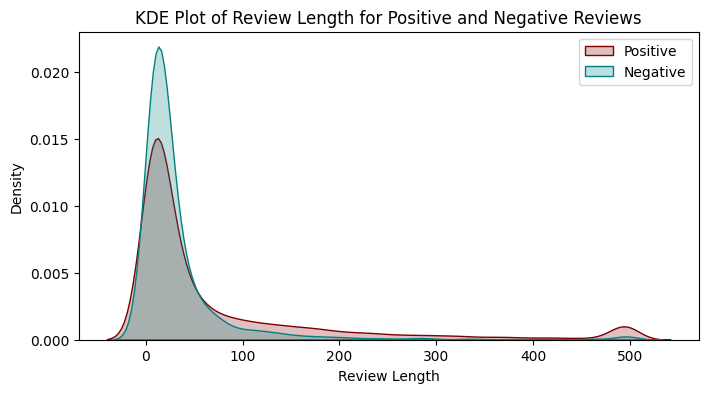

In [79]:
# Set up figure and axis
plt.figure(figsize=(8, 4))

# KDE plot for length of positive reviews
sns.kdeplot(products_data[products_data['polarity'] == 'positive']['review'].apply(len), label='Positive', color='maroon', fill=True)

# KDE plot for length of negative reviews
sns.kdeplot(products_data[products_data['polarity'] == 'negative']['review'].apply(len), label='Negative', color='teal', fill=True)

plt.title('KDE Plot of Review Length for Positive and Negative Reviews')
plt.xlabel('Review Length')
plt.ylabel('Density')
plt.legend()

plt.show()

1. **Skewed Distribution:**
   - The KDE plots reveal that both positive and negative review lengths are skewed towards the left side of the length spectrum.
   - This suggests that a significant portion of reviews, regardless of sentiment, tends to be relatively shorter in length.

2. **Commonality in Conciseness:**
   - The concentration of density towards the shorter lengths implies that many users express their opinions concisely in their reviews.
   - Users may prefer to convey their sentiments succinctly, capturing the essence of their experience without extensive elaboration.

3. **Quick Glance Insights:**
   - The prominent density on the left indicates that readers can quickly gain insights from reviews, as they are more likely to encounter shorter texts.
   - This aligns with the modern trend of users preferring easily digestible information in the form of brief reviews.

4. **Potential for Bias:**
   - The left-skewed distribution raises the possibility of potential bias in review lengths, as users may be more inclined to share shorter reviews.
   - Understanding this bias is crucial for interpreting and analyzing user sentiments accurately.

5. **Review Platform Characteristics:**
   - The platform's interface or review submission process may contribute to the observed distribution, encouraging users to provide succinct feedback.
   - Platform features that facilitate concise expression may influence the overall length patterns in both positive and negative reviews.

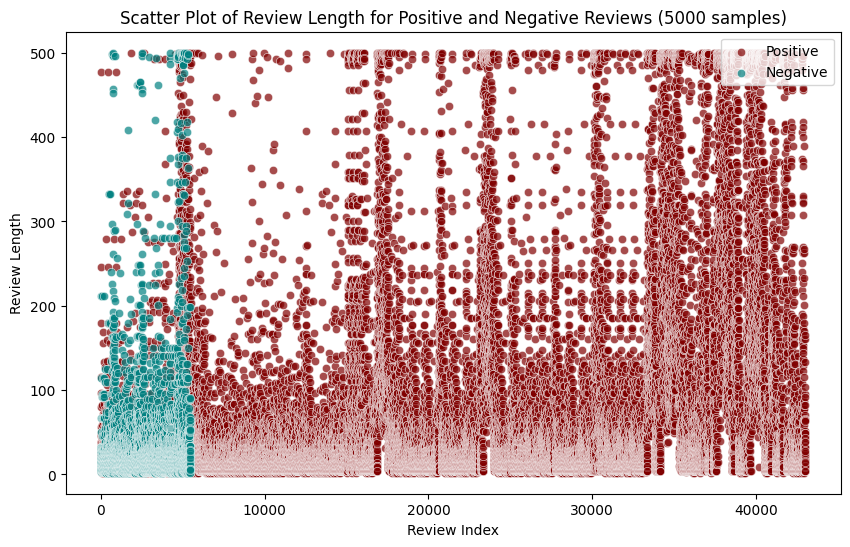

In [80]:
# Set up figure and axis
plt.figure(figsize=(10, 6))

# Scatter plot for length of positive reviews
sns.scatterplot(x=range(len(products_data[products_data['polarity'] == 'positive'])),
                y=products_data[products_data['polarity'] == 'positive']['review'].apply(len),
                label='Positive', color='maroon', alpha=0.7)

# Scatter plot for length of negative reviews
sns.scatterplot(x=range(len(products_data[products_data['polarity'] == 'negative'])),
                y=products_data[products_data['polarity'] == 'negative']['review'].apply(len),
                label='Negative', color='teal', alpha=0.7)

plt.title('Scatter Plot of Review Length for Positive and Negative Reviews (5000 samples)')
plt.xlabel('Review Index')
plt.ylabel('Review Length')
plt.legend(loc='upper right')
plt.show()

- **Concentration of Negative Reviews:**
  The scatter plot reveals a concentration of negative reviews within the review length range of 10 to 200. This indicates that a majority of users expressing negative sentiments tend to provide relatively shorter comments.

- **Variability in Negative Reviews:**
  While the majority falls within the 10-200 range, there are noticeable instances of negative reviews with higher lengths. This suggests that some users choose to provide more detailed and extensive feedback when expressing dissatisfaction.

- **Positive Reviews' Length Distribution:**
  Positive reviews exhibit a broader distribution in terms of review length, ranging from short to long. The scatter plot indicates a more diverse set of lengths for positive comments compared to negative ones.

- **High Length Positive Reviews:**
  There is a visible presence of positive reviews with higher lengths, indicating that users expressing positive sentiments are more likely to provide detailed and extensive feedback. This contrasts with the more concentrated distribution of shorter comments in negative reviews.




---



### **Text Preprocessing**

**Preprocessing Phase-1**
- HTML Parsing and Cleanup
- Unicode Normalization
- Emoticons decoding

In [81]:
!pip install demoji

In [82]:
# removal of urls/links
import re
def remove_url(text):
    text = re.sub(r"http\S+", "", text)
    return text


# handling of emoticons
import demoji
def handle_emoji(string):
    emojis = demoji.findall(string)

    for emoji in emojis:
        string = string.replace(emoji, " " + emojis[emoji].split(":")[0])

    return string


**Preprocessing Phase-2**
  - Sentence segmentation and word tokenization.
  - Stop word removal, stemming and lemmatization
  - removing digits/punctuation, lowercasing, etc.

In [83]:
import spacy
sm_model = spacy.load("en_core_web_sm")

In [84]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [85]:
!pip install nlpaug

In [86]:
# word tokenisation
def word_tokenizer(text):
    text = text.lower()
    text = text.split()
    return text


# removal of stopwords
from nltk.corpus import stopwords
en_stopwords = set(stopwords.words('english'))
def remove_stopwords(text):
    text = [word for word in text if word not in en_stopwords]
    return text


# stemming
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

stemmer = PorterStemmer()
def stemming(text):
    text = [stemmer.stem(word) for word in text]
    return text


# lemmatisation
def lemmatization(text):
    text = " ".join(text)
    token = sm_model(text)
    text = [word.lemma_ for word in token]
    return text

In [87]:
products_data_processed = products_data.copy()

In [88]:
# processing labels
from tqdm import tqdm
def label(y):
    if y == '5':
        return 1
    elif y == '4':
        return 1
    else:
        return 0


tqdm.pandas()
products_data_processed['processed_label'] = products_data.ratings.progress_map(label)

100%|██████████| 48488/48488 [00:00<00:00, 129254.49it/s]


In [89]:
products_data_processed = products_data_processed[['review', 'processed_label', 'ratings']]

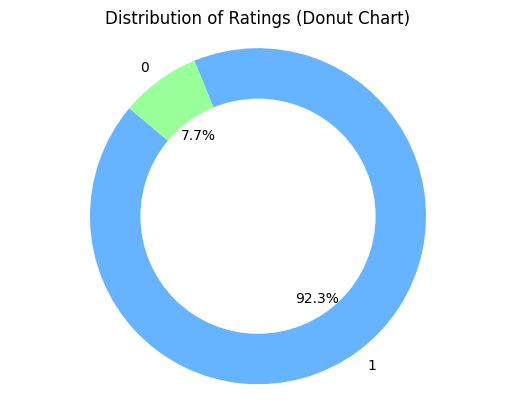

In [90]:
# Ratings data
ratings_counts = list(products_data_processed.processed_label.value_counts().values)

# Corresponding labels
labels = list(products_data_processed.processed_label.value_counts().index)

# Colors for each rating
colors = ['#66b3ff', '#99ff99', '#ffcc99']

# Create pie chart
fig, ax = plt.subplots()
ax.pie(ratings_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops=dict(width=0.4))

# Draw a circle at the center to make it look like a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Add a title
plt.title('Distribution of Ratings (Donut Chart)')

# Show the plot
plt.show()


Our dataset lacks a substantial number of negative comments. To address this imbalance, we intend to use data augmentation techniques. Our approach involves selecting sentences with a 5-star rating and filtering reviews within a word count range of 20 to 30 words.

Subsequently, we will use **Antonym Augmentation** to systematically generate corresponding negative reviews.

#### **Antonymn Augmentation for Balancing Negative Reviews**

This section will augment the sentences of positive reviews by converting some token into their antonymn form (reversing the sentiment).

In [91]:
products_data_processed_positive = products_data_processed[(products_data_processed['ratings'] == '5')]

In [92]:
positive_reviews_data = list(products_data_processed_positive[(products_data_processed_positive['review'].str.len() > 100)
                            & (products_data_processed_positive['review'].str.len() < 350)]['review'])
len(positive_reviews_data)

4803

In [93]:
import nlpaug.augmenter.word as naw

In [94]:
import nltk

# Download the specific 'averaged_perceptron_tagger_eng' resource
nltk.download('averaged_perceptron_tagger_eng')

# Your existing code for augmentation
import nlpaug.augmenter.word as naw

augmentation_instance = naw.AntonymAug(name='Antonym_Aug', aug_min=1, aug_max=10, aug_p=0.3, lang='eng', stopwords=en_stopwords, tokenizer=None,
                     reverse_tokenizer=None, stopwords_regex=None, verbose=0)

augmented_negative_reviews = augmentation_instance.augment(positive_reviews_data)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [95]:
augmentation_instance = naw.AntonymAug(name='Antonym_Aug', aug_min=1, aug_max=10, aug_p=0.3, lang='eng', stopwords=en_stopwords, tokenizer=None,
                     reverse_tokenizer=None, stopwords_regex=None, verbose=0)

augmented_negative_reviews = augmentation_instance.augment(positive_reviews_data)

In [96]:
len(augmented_negative_reviews)

4803

In [97]:
products_data_negative_reviews = pd.DataFrame({"review" : augmented_negative_reviews, 'processed_label' : [0]*len(augmented_negative_reviews)})
products_data_positive_reviews = pd.DataFrame({"review" : positive_reviews_data, 'processed_label' : [1]*len(positive_reviews_data)})

products_data_processed = pd.concat([products_data_negative_reviews, products_data_positive_reviews]).sample(frac = 1, random_state = 11).reset_index(drop=True)
products_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9606 entries, 0 to 9605
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review           9606 non-null   object
 1   processed_label  9606 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 150.2+ KB


In [98]:
## cleaning and pre-processing
import unicodedata as uni
def preprocess_review(text):
  text = remove_url(text)
  text = uni.normalize('NFKD', text)
  text = handle_emoji(text)
  text = text.lower()
  text = re.sub(r'[^\w\s]', '', text)
  text = word_tokenizer(text)
  text = lemmatization(text)
  text = remove_stopwords(text)
  text = " ".join(text)

  return text

In [ ]:
tqdm.pandas()
products_data_processed['processed_review'] = products_data_processed['review'].progress_map(preprocess_review)

 26%|██▋       | 2526/9606 [00:43<02:07, 55.61it/s]

In [ ]:
%%capture
!pip install textblob
from textblob import TextBlob

In [ ]:
# Define a function to get sentiment polarity
def get_sentiment(text):
    analysis = TextBlob(text)
    # Classify polarity as positive, negative, or neutral
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity <= 0:
        return 'negative'
    # else:
    #     return 'neutral'

# Apply the function to the 'processed_review' column and create a new 'sentiments' column
products_data_processed['sentiments'] = products_data_processed['processed_review'].apply(get_sentiment)

# Display the updated DataFrame
products_data_processed.head()

In [ ]:
products_data_processed.sentiments.value_counts()

In [ ]:
processed_reviews = products_data_processed.processed_review.values.tolist()

tqdm.pandas()
products_data_processed['processed_review_tokenized'] = products_data_processed['processed_review'].progress_map(word_tokenizer)
products_data_processed.head(3)

In [ ]:
count=0
for i in range(len(products_data_processed)):
  if (products_data_processed['processed_label'][i]==0 and products_data_processed['sentiments'][i]=='negative'):
    pass
  elif(products_data_processed['processed_label'][i]==1 and products_data_processed['sentiments'][i]=='positive'):
    pass
  else:
    count=count+1
    print(products_data_processed['processed_label'][i])
    print(products_data_processed['sentiments'][i])
    print(products_data_processed['processed_review'][i])

In [ ]:
nltk.download('punkt')

In [ ]:
import pandas as pd
from textblob import TextBlob
from nltk import FreqDist, pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Sample DataFrame with processed reviews
# Replace this with your actual DataFrame
data = {'processed_review': ["awesome phone great value money battery backup bad performance phone really awesome I like",
                             "Excellent battery backup but the phone is heavy",
                             "The phone has a sleek design and good camera quality"]}
temp_products_data_processed = products_data_processed#pd.DataFrame(data)

# Tokenize and clean text
stop_words = set(stopwords.words('english'))

def tokenize_and_clean(text):
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha() and word not in stop_words]

# Apply tokenization and cleaning to each review
temp_products_data_processed['tokenized_review'] = temp_products_data_processed['processed_review'].apply(tokenize_and_clean)

# Define positive and negative words
positive_words = ['good', 'awesome', 'excellent']
negative_words = ['bad', 'poor', 'heavy']

# Function to check if a word is a positive or negative word
def is_positive_or_negative(word):
    if word in positive_words:
        return 'positive'
    elif word in negative_words:
        return 'negative'
    else:
        return None

# Flatten the list of tokenized reviews
all_tokens = [token for tokens in temp_products_data_processed['tokenized_review'] for token in tokens]

# Identify noun phrases as potential aspects
noun_phrases = [phrase for phrase, pos in pos_tag(all_tokens) if pos.startswith('NN')]

# Calculate term frequencies for noun phrases
freq_dist = FreqDist(noun_phrases)

# Filter out positive and negative words
key_aspects = [(aspect, freq) for aspect, freq in freq_dist.most_common() if is_positive_or_negative(aspect) is None]

# Display key aspects
print("Key Aspects:")
for aspect, frequency in key_aspects:
    print(f"{aspect}: {frequency} mentions")


In [ ]:
products_data_processed.head()

In [ ]:
aspects = []
for i in range(8):
  aspects.append(key_aspects[:8][i][0])

In [ ]:
products_data_processed.head(2)

In [ ]:
products_data_processed.to_csv('flipkart_dummy.csv', index=False)

In [ ]:
'''
Furthermore, the aspect and sentiment assignment has been done in encode.py file.
This file detects possible aspect based keywords analysing overall reviews.
After detecting aspects, each review is processed with respect to the specific aspect
and a prominant sentiment is assigned to each review, making the data - labelled.
'''